<a href="https://colab.research.google.com/github/Jitendra4Jalwaniya/tf_learning/blob/main/site/en/tutorials/multi_class_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.17.1


In [18]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file(
    "stack_overflow_16k",
    url,
    untar = True,
    cache_dir = ".",
    cache_subdir = ""
)
dataset_dir = os.path.dirname(dataset)

In [19]:
os.listdir(dataset_dir)

['.config',
 'README.md',
 'test',
 'stack_overflow_16k.tar.gz',
 'train',
 'sample_data']

In [20]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['java', 'javascript', 'csharp', 'python']

In [21]:
test_dir = os.path.join(dataset_dir, "test")
os.listdir(test_dir)

['java', 'javascript', 'csharp', 'python']

In [27]:
train_java_dir = os.path.join(train_dir, "java")
train_java_list = os.listdir(train_java_dir)
print(train_java_list[:5])
print(train_java_list[0])

['128.txt', '778.txt', '354.txt', '1126.txt', '1272.txt']
128.txt


In [28]:
sample_file = os.path.join(train_java_dir, '128.txt')
with open(sample_file) as f:
  print(f.read())

"blank: missing variable as dice and value three dice objects and toss each one. the results of the toss should be displayed in an output window. i'm working on this exercise. i've two classes: app and dice classes to work with, that's it...i'm not sure how to make it work in class app. correct me if i've mistaken on class app as below. ..updated: ..there is an error on class app that read no variable and i've used ""dice"" as dice [ 1 ] incorrectly and it should read as face.value instead. using the accepted answer as below"" **dice: ""+ facevalue. as a solution for code of the following:.//updated code and corrected.obox.println( ""you threw : "" + diceone.getfacevalue() + "" "" + dicetwo.getfacevalue() + "" "" + dicethree.getfacevalue() );**..class app as below..import blankbook.*;..class app.{..public static void main(string args[]).{.    app thisprogram = new app();.    //scanner input= new scanner(system.in);..}   .    //outside a main class.    public app().    {..        //cont

In [29]:
print(
    len(os.listdir(os.path.join(train_dir,"java"))),
    len(os.listdir(os.path.join(train_dir,"javascript"))),
    len(os.listdir(os.path.join(train_dir,"csharp"))),
    len(os.listdir(os.path.join(train_dir,"python"))),
    len(os.listdir(os.path.join(test_dir,"java"))),
    len(os.listdir(os.path.join(test_dir,"javascript"))),
    len(os.listdir(os.path.join(test_dir,"csharp"))),
    len(os.listdir(os.path.join(test_dir,"python"))),
)

2000 2000 2000 2000 2000 2000 2000 2000


In [32]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [33]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [34]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [35]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [36]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [37]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [38]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [39]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [40]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [41]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Question", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Question tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3, 

In [42]:
print("1011 ---> ",vectorize_layer.get_vocabulary()[1011])
print(" 773 ---> ",vectorize_layer.get_vocabulary()[773])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1011 --->  unit
 773 --->  testing
Vocabulary size: 10000


In [43]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
embedding_dim = 16

In [46]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3039 - loss: 1.3777 - val_accuracy: 0.3812 - val_loss: 1.3535
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4070 - loss: 1.3395 - val_accuracy: 0.4425 - val_loss: 1.2983
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4965 - loss: 1.2769 - val_accuracy: 0.5931 - val_loss: 1.2166
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5721 - loss: 1.1960 - val_accuracy: 0.6319 - val_loss: 1.1327
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6041 - loss: 1.1152 - val_accuracy: 0.6719 - val_loss: 1.0539
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6487 - loss: 1.0360 - val_accuracy: 0.7025 - val_loss: 0.9835
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6839 - loss: 0.9674 - val_accuracy: 0.6975 - val_loss: 0.9212
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7071 - loss: 0.9071 - val_accuracy: 0.7094 - val

In [49]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7551 - loss: 0.7654
Loss:  0.756719172000885
Accuracy:  0.7592499852180481


In [50]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

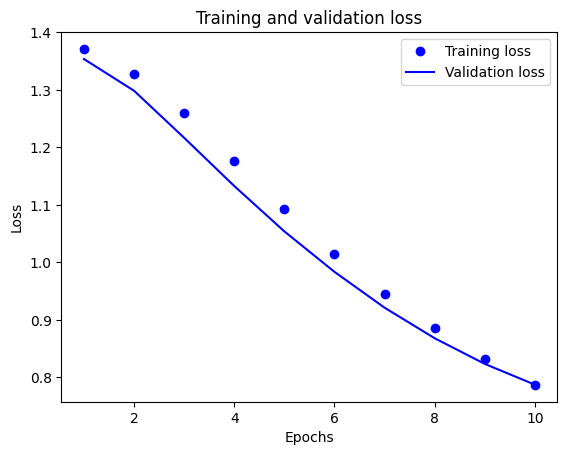

In [51]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

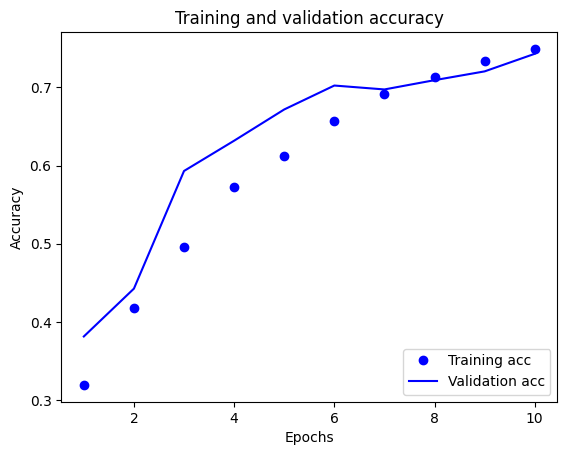

In [52]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [56]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7556 - loss: 0.0000e+00
{'accuracy': 0.7592499852180481, 'loss': 0.0}


In [62]:
examples = tf.constant([
  "how to read data from dictionary and what is django list set dictionary",
  "what are callback functions and async and await",
])

import numpy as np

predictions = export_model.predict(examples)
prediction_0 = np.argmax(predictions[0])
prediction_1 = np.argmax(predictions[1])
print(prediction_0, prediction_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0 2
